# Parameter Tuning

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import multiprocessing
from matplotlib import cm

2024-07-26 19:56:36.464479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 19:56:36.464514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 19:56:36.465398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 19:56:36.470290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 19:56:37.006100: W tensorflow/compiler/tf2

In [ ]:
def one_hot(x, depth):                    #To convert label into vector (To calculate loss it is easier to encode label to vectors)
    res=[]
    for i in range(len(x)):
        tmp = np.zeros((depth,))
        tmp[x[i]] = 1
        res.append(tmp)
    res = np.array(res)
    return res

(train_data, train_label), (test_data, test_label) =mnist.load_data()

train_data = train_data.reshape((60000, 28*28))
test_data = test_data.reshape((10000, 28*28))

test_label = one_hot(test_label, 10)
train_label = one_hot(train_label, 10)

train_data = train_data / 255             #Normalize Data (For Better Learning)

'''
There are Layers required to implement simple Feed Forward Network
__init__ initializes the Weights and Biases and Gradient arrays for a layer
operate  method will do the operation of particular layer
ret      method will return 'matmul(W,X) + B' of particular layer, this is required because
         we calculate gradient using chain rule starting from the output layer and going back to the input layer
         At any point we know "Gradient of Loss wrt to Activation of current Layer" and we want to calculate "grad W" and "grad B"
         but to do this we requires activation of prev layer since activation of current = relu(matmul(W,X) + B)
'''
class Input():
    def __init__(self, shape):
        self.shape = shape
        self.prev = None

    def operate(self, x):
        self.Z = np.array(x, copy=True)
        return self.Z

class Dense():
    def __init__(self, shape, prev):
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.act = 'relu'

    def operate(self, x):
#         self.Z = np.matmul(self.W, x) + self.B
#         return relu(self.Z)

        self.Z = relu(np.matmul(self.W, x) + self.B)
        return self.Z

    def ret(self, x):
        return self.Z

class Output():
    def __init__(self, shape, prev):
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.act = 'softmax'

    def operate(self, x):
#         self.Z = np.matmul(self.W, x) + self.B
#         return softmax(self.Z)

        self.Z = softmax(np.matmul(self.W, x) + self.B)
        return self.Z

    def ret(self, x):
        return self.Z

In [ ]:
def relu(x):
  #To create nonlinearity, this is to make neural network learn nonlinear function
  #without this neural netowrk will only learn to scale and bias the input, no matter how many layers we use
    return np.maximum(0,x)

def softmax(X):
  #Softmax activation function is used to genrate probablity from activation of Neural Network
  #Softmax function property: Softmax(X) = Softmax(X - C) C is any constant
  #This creates numerical stablity and avoid overflows and NaN
    Z = X - np.max(X)
    return np.exp(Z)/(np.sum(np.exp(Z), axis=0))

def grad_Z(w, z_curr, z_prev, dz_next, act):        #This is hardcoded chain rule to calculate gradient of loss wrt Z of current layer
    if act == "relu":
        temp = np.einsum("j,j -> j", dz_next, (z_curr > 0))
        grad = np.einsum("ji,j -> i", w, temp)

    elif act == "softmax":
        temp1 = np.einsum("i,j -> ij", z_curr, -1*z_curr)
        temp2 = np.identity(z_curr.shape[0])*z_curr
        a = np.add(temp1, temp2)
        b = np.einsum("ij,j -> ij", a, dz_next)
        c = np.sum(b, axis=1)
        grad = np.einsum("ij, i -> j", w, c)
    return grad

def grad_W(w, z_curr, z_prev, dz_next, act):         #This is hardcoded chain rule to calculate gradient of loss wrt W of current layer
    if act == "relu":
        temp = np.einsum("j, j -> j", dz_next, (z_curr > 0))
        grad = np.einsum("j, i -> ji", temp, z_prev)

    elif act == "softmax":
        temp1 = np.einsum("i,j -> ij", z_curr, -1*z_curr)
        temp2 = np.identity(z_curr.shape[0])*z_curr
        a = np.add(temp1, temp2)
        b = np.einsum("ij,j -> ij", a, dz_next)
        c = np.sum(b, axis=1)
        grad = np.einsum("i,j -> ij", c, z_prev)
    return grad

def grad_B(b, z_curr, z_prev, dz_next, act):              #This is hardcoded chain rule to calculate gradient of loss wrt Z of current layer
    if act == "relu":
        grad = np.einsum("i,i -> i", dz_next, (z_curr > 0))

    elif act == "softmax":
        temp1 = np.einsum("i,j -> ij", z_curr, -1*z_curr)
        temp2 = np.identity(z_curr.shape[0])*z_curr
        a = np.add(temp1, temp2)
        b = np.einsum("ij,j -> ij", a, dz_next)
        c = np.sum(b, axis=1)
        grad = c
    return grad

In [ ]:
class model():                                      #This is to orgainse the computation in proper way
    def __init__(self):
        self.batch_acc = []
        self.loss = []

    def make(self, inputs, outputs, optimizer):    #This is add the sequence of layers to a array comp_graph so we can know the neighboring layers of a given layer
        self.comp_graph = []
        self.input_layer = inputs
        self.output_layer = outputs
        self.opt = optimizer
        i = outputs
        while i!= None:
            self.comp_graph.append(i)
            i=i.prev

        if (optimizer == "adam"):
            self.adam_init()
            self.optimizer = self.adam
        elif (optimizer == "RMSprop"):
            self.RMSprop_init()
            self.optimizer = self.RMSprop
        else:
            self.optimizer = self.SGD

    def SGD(self, x, grad, layer, sub_typ):
        return (x - self.step_size*grad)

    def adam_init(self):
        #Hyper Parameters
        self.e = 10e-8

        #t, m, v STORING THE HISTORY
        self.pram = {i:{'W':{'t':0, 'm':np.zeros(i.W.shape), 'v':np.zeros(i.W.shape)},
                        'B':{'t':0, 'm':np.zeros(i.B.shape), 'v':np.zeros(i.B.shape)}} for i in self.comp_graph[:-1]}

    def adam(self, x, grad, layer, sub_typ):
        self.pram[layer][sub_typ]['t'] += 1
        self.pram[layer][sub_typ]['m'] = self.b1 * self.pram[layer][sub_typ]['m'] + (1-self.b1) * (np.power(grad,1))
        self.pram[layer][sub_typ]['v'] = self.b2 * self.pram[layer][sub_typ]['v'] + (1-self.b2) * (np.power(grad,2))
        corr_m = self.pram[layer][sub_typ]['m']/(1 - np.power(self.b1, self.pram[layer][sub_typ]['t']))
        corr_v = self.pram[layer][sub_typ]['v']/(1 - np.power(self.b2, self.pram[layer][sub_typ]['t']))
        corr_m = self.pram[layer][sub_typ]['m']
        corr_v = self.pram[layer][sub_typ]['v']
        x = x - self.a * (corr_m/(np.add(np.power(corr_v, 0.5), self.e)))
        return x

    def RMSprop_init(self):
        self.e = 10e-8
        self.pram = {i:{'W':{'v':np.zeros(i.W.shape)},
                        'B':{'v':np.zeros(i.B.shape)}} for i in self.comp_graph[:-1]}
    def RMSprop(self, x, grad, layer, sub_typ):
        self.pram[layer][sub_typ]['v'] = self.b2 * self.pram[layer][sub_typ]['v'] + (1-self.b2) * (np.power(grad,2))
        x = x - self.a * (grad/(np.add(np.power(self.pram[layer][sub_typ]['v'], 0.5), self.e)))
        return x

    def fit(self, X, Y, v = False, return_dict = {}):

        Y.flags.writeable = False
        X.flags.writeable = False
        correct_pred = 0
        cost = 0

        for i in tqdm(range(len(X)), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', disable = v):
            #forward pass

            x = self.input_layer.operate(X[i])
            for j in range(-1, -1*len(self.comp_graph)-1, -1):
                x = self.comp_graph[j].operate(x)

            if np.argmax(x) == np.argmax(Y[i]):
                correct_pred += 1

            #backward pass
            #Signatures
            #grad_W(w, z_curr, z_prev, dz_next, act)
            #grad_B(b, z_curr, dz_next, act)

            cost = (i/(i+1))*cost + (1/(i+1))*np.sum(np.power(Y[i] - self.output_layer.Z, 2))
            self.loss.append(cost)
            grad_loss = dz_next = (-2)*(Y[i] - self.output_layer.Z)
            comp_graph = self.comp_graph

            for l in comp_graph[:-1]:
                grad_w = grad_W(l.W, l.Z, l.prev.Z, dz_next, l.act)
                grad_b = grad_B(l.B, l.Z, l.prev.Z, dz_next, l.act)
                dz_next = grad_Z(l.W, l.Z, l.prev.Z, dz_next, l.act)
                l.W = self.optimizer(l.W, grad_w, l, "W")
                l.B = self.optimizer(l.B, grad_b, l, "B")

            if (i%32 == 0):
                self.batch_acc.append(correct_pred/32)
                correct_pred = 0

        if self.opt == "SGD":
            return_dict[self.step_size] = (self.batch_acc, self.loss)
        elif self.opt == "adam":
            return_dict[(self.a, self.b1, self.b2)] = (self.batch_acc, self.loss)
        elif self.opt == "RMSprop":
            return_dict[(self.a, self.b2)] = (self.batch_acc, self.loss)


    def predict (self, X):
        x = self.input_layer.operate(X)
        for i in range(-1, -1*len(self.comp_graph)-1, -1):
            x = self.comp_graph[i].operate(x)
        return x

In [ ]:
#For consistency we use same step size in all initialization
#Here we make a random initialization and store it for future

inputs = Input(28*28)
x = Dense(50 ,inputs)
outputs = Output(10 ,x)

digit_classifier = model()

x_W = x.W.copy()
x_B = x.B.copy()

outputs_W = outputs.W.copy()
outputs_B = outputs.B.copy()

# Multiprocessing Implementation for Parameter Sweep

In [ ]:
def parameter_sweep(opt, arg_param, end_idx = 60000):
    steps = []
    if opt == "SGD":
        steps = arg_param
    elif opt == "adam":
        for a in arg_param[0]:
            for b1 in arg_param[1]:
                for b2 in arg_param[2]:
                    steps.append((a,b1,b2))
    elif opt == "RMSprop":
        for a in arg_param[0]:
            for b in arg_param[1]:
                steps.append((a,b))

    digit_classifiers = []

    for i in steps:
        #Building Models to run in parallel
        inputs = Input(28*28)

        x = Dense(50 ,inputs)
        x.W = x_W.copy()
        x.B = x_B.copy()

        outputs = Output(10 ,x)
        outputs.W = outputs_W.copy()
        outputs.B = outputs_B.copy()

        digit_classifier = model()

        if opt == "SGD":
            digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="SGD")
            digit_classifier.step_size = i
        elif opt == "adam":
            digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="adam")
            digit_classifier.a = i[0]
            digit_classifier.b1 = i[1]
            digit_classifier.b2 = i[2]
        elif opt == "RMSprop":
            digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="RMSprop")
            digit_classifier.a = i[0]
            digit_classifier.b2 = i[1]

        digit_classifiers.append(digit_classifier)

    processes = []
    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    args = [train_data[:end_idx], train_label[:end_idx], True, return_dict]

    for i in range(len(steps)):
        if i == 0:
            p = multiprocessing.Process(target = digit_classifiers[i].fit, args = [train_data[:end_idx],
                                                                    train_label[:end_idx], False, return_dict])
        else:
            p = multiprocessing.Process(target = digit_classifiers[i].fit, args = args)
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return return_dict

## Doing Paramter Sweep to determine best step size SGD


100%|██████████| 60000/60000 [00:20<00:00, 2886.43it/s]                                                     


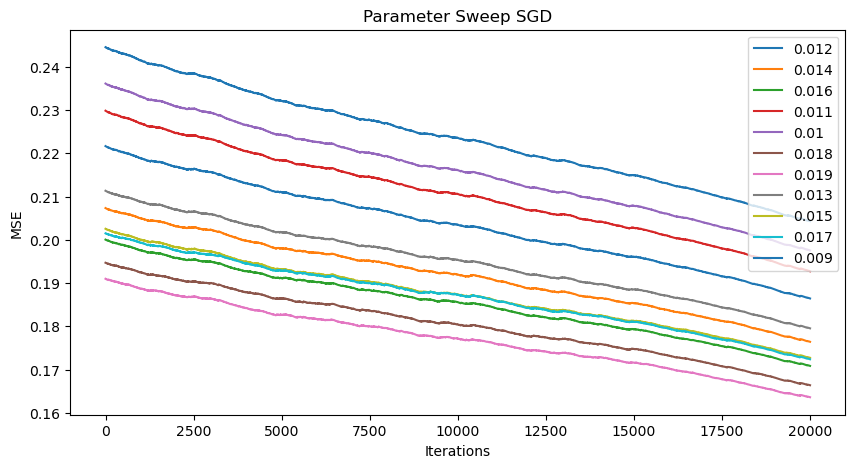

In [ ]:
#Perform a parameter sweep for SGD

steps = np.arange(0.8e-2, 2e-2, 1e-3)[1:]
return_dict = parameter_sweep("SGD",steps)

plt.figure(figsize=(10,5))
plt.xlabel("Iterations")
plt.ylabel("MSE")
for step in return_dict:
    plt.plot(range(len(return_dict[step][1][40000:])),return_dict[step][1][40000:], label=f"{round(step,3)}")
plt.title("Parameter Sweep SGD")
plt.legend()
plt.show()

# We observer 0.019 is best step size

## Doing Paramter Sweep to determine best step size (a) Adam

100%|██████████| 60000/60000 [01:48<00:00, 552.41it/s]                                                      


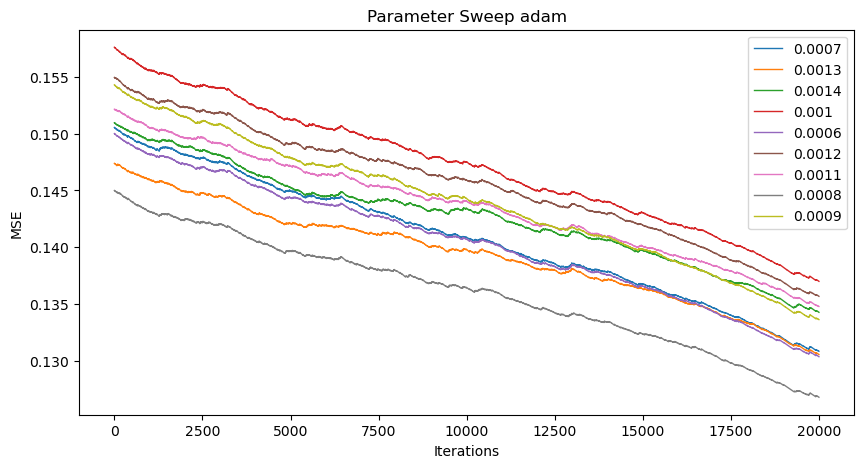

In [ ]:
a_sweep = np.arange(0.5e-3, 1.5e-3, 0.1e-3)[1:]
b1_sweep = [0.9]
b2_sweep = [0.999]
return_dict = parameter_sweep("adam",[a_sweep, b1_sweep, b2_sweep])

plt.figure(figsize=(10,5))
plt.xlabel("Iterations")
plt.ylabel("MSE")
for step in return_dict:
    plt.plot(range(len(return_dict[step][1][40000:])),return_dict[step][1][40000:], label=f"{round(step[0],4)}", linewidth = 1)
plt.title("Parameter Sweep adam")
plt.legend()
plt.show()

# 0.0008 step size is best

## Doing Paramter Sweep to determine best b1, b2 for a = 0.0008 Adam

100%|██████████| 5000/5000 [01:16<00:00, 65.13it/s]                                                         


<IPython.core.display.Javascript object>


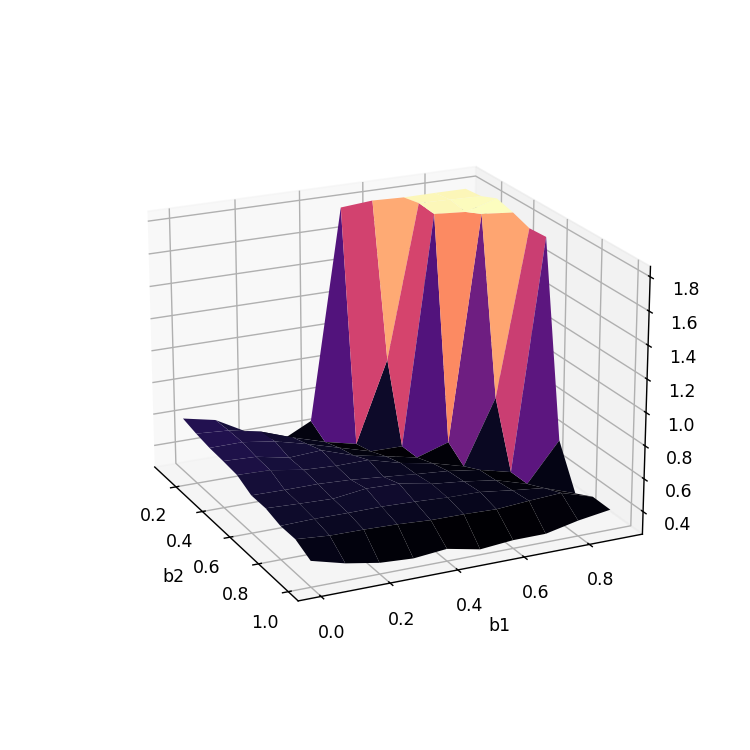

Text(0.5, 0.5, 'b1')

In [ ]:
a_sweep = [0.008]
b1_sweep = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
b2_sweep = [0.099, 0.199, 0.299, 0.399, 0.499,0.599, 0.699, 0.799, 0.899, 0.999]
return_dict = parameter_sweep("adam",[a_sweep, b1_sweep, b2_sweep], 5_000)

def comp(x):
    return x[1]*len(b1_sweep) + x[2]

keys = return_dict.keys()
keys.sort(key = comp)

%matplotlib notebook
X,Y = np.meshgrid(b2_sweep, b1_sweep)
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i][j] = return_dict[keys[X.shape[1]*i+j]][1][-1]

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.magma)
plt.xlabel("b2")
plt.ylabel("b1")

#Strongly influenced by b2
#High b2 and any b1 works well
#b1 = 0.5, b2 = 0.999 provides the best MSE

# Parameter Sweep for step size(a) and varience estimate(b) for RMSprop

100%|██████████| 5000/5000 [00:41<00:00, 121.21it/s]                                                        


<IPython.core.display.Javascript object>


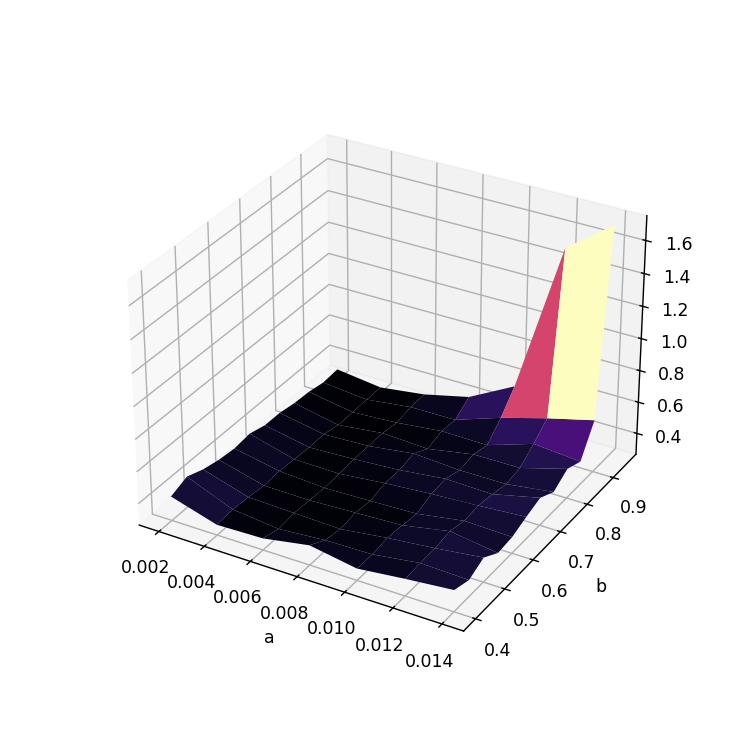

Text(0.5, 0.5, 'b')

In [ ]:
a_sweep = [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014]
b_sweep = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
return_dict = parameter_sweep("RMSprop",[a_sweep, b_sweep], 5_000)

def comp(x):
    return x[1]*len(a_sweep) + x[0]

keys = return_dict.keys()
keys.sort(key = comp)

%matplotlib notebook
X,Y = np.meshgrid(a_sweep, b_sweep)
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i][j] = return_dict[keys[X.shape[1]*i+j]][1][-1]

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.magma)
plt.xlabel("a")
plt.ylabel("b")

# a = 0.006 and b = 0.6 works well